In [1]:
from hapin import *
#from pylab import plot
#import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lm
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from scipy import interpolate
import sys

HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:
db_begin('data/CO-data')

Using data/CO-data

23um05_HITEMP2019
                     Lines parsed: 1632


In [3]:
od_nu=4284
do_nu=4286

nu_res=0.001

OmegaGrid = np.arange(od_nu, do_nu, nu_res)

print(OmegaGrid)

ela = 10

volfr_h2o=0.18
volfr_n2= 0.71
volfr_co2=0.10
volfr_co= 0.02

print(ela)

P_env = 1
T_env = 1500
P_ref = 1
T_ref = 296
#p_self=1
#p_self = volfr_h2o*P_env
p_self = volfr_co*P_env


NSL_min = 1.0e-23

print(P_env,T_env,P_ref,T_ref,p_self)

cond = ('AND', ('BETWEEN','nu',od_nu,do_nu),('>=','sw',1e-45))

#select('23um01_HITEMP2010', ParameterNames=('nu','sw','delta_air','gamma_air','gamma_self','molec_id','local_iso_id','elower','n_air'),Conditions=cond,DestinationTableName='H2O-select')
select('23um05_HITEMP2019', Conditions=cond,DestinationTableName='CO-select')

print(LOCAL_TABLE_CACHE['CO-select']['data'].keys())
       
nue,sw,delta_air,gamma_air,gamma_self,molec_id,local_iso_id,elower,n_air = getColumns('CO-select',['nu','sw','delta_air','gamma_air','gamma_self','molec_id','local_iso_id','elower','n_air'])

[4284.    4284.001 4284.002 ... 4285.997 4285.998 4285.999]
10
1 1500 1 296 0.02
dict_keys(['molec_id', 'local_iso_id', 'nu', 'sw', 'a', 'gamma_air', 'gamma_self', 'elower', 'n_air', 'delta_air', 'global_upper_quanta', 'global_lower_quanta', 'local_upper_quanta', 'local_lower_quanta', 'ierr', 'iref', 'line_mixing_flag', 'gp', 'gpp'])


In [4]:
nu, coef_HT = absorptionCoefficient_HT(
    SourceTables='CO-select',
    Environment={'T': T_env, 'p': P_env},
    OmegaGrid=OmegaGrid,
    Diluent={'self': volfr_co,'H2O': volfr_h2o, 'air': volfr_n2, 'CO2': volfr_co2},
    #HITRAN_units=False
)
nu, coef_Voigt = absorptionCoefficient_Voigt(
    SourceTables='CO-select',
    Environment={'T': T_env, 'p': P_env},
    OmegaGrid=OmegaGrid,
#    Diluent={'self': volfr_co,'H2O': volfr_h2o, 'air': volfr_n2, 'CO2': volfr_co2}
     Diluent={'self': volfr_co, 'air': 1.0}
)

{'self': 0.02, 'H2O': 0.18, 'air': 0.71, 'CO2': 0.1}
0.007103 seconds elapsed for abscoef; nlines = 5
{'self': 0.02, 'air': 1.0}
0.005148 seconds elapsed for abscoef; nlines = 5


In [5]:
#plt.plot(nu,coef_HT,'orange',nu, coef_Voigt,'lime') # plot both profiles
#plt.xlim(od_nu, do_nu)
#plt.plot(nu,coef_HT-coef_Voigt)
#plt.show()

In [6]:
sum_lor=np.zeros(len(nu))
sum_voi=np.zeros(len(nu))

lor=[np.zeros(len(nu))]*len(nue)
voi=[np.zeros(len(nu))]*len(nue)

nux=[np.zeros(len(nu))]*len(nue)
g2f=[np.zeros(len(nu))]*len(nue)

delta=np.zeros(len(nue))
gammaD=np.zeros(len(nue))
gammaL=np.zeros(len(nue))
gammaLD=np.zeros(len(nue))
gammaLD1=np.zeros(len(nue))
gammaLD2=np.zeros(len(nue))
n_self=np.zeros(len(nue))

sw_env=np.zeros(len(nue))
nsl=np.zeros(len(nue))
vline=np.zeros(len(nue))
dvline=np.zeros(len(nue))
a0=np.zeros(len(nue))
#mW=np.ones(len(nue))

#I0=np.ones(len(nue))
#I0 = []
#for i in range(len(nue)):
#    I0.append(PowerFit(nue[i]))

In [7]:
AvogN = 6.02214129e23
c2=1.43877
fSqrtMass = sqrt(molecularMass(molec_id[0],local_iso_id[0]))

Q_env = partitionSum(molec_id[0],local_iso_id[0],T_env)
Q_ref = partitionSum(molec_id[0],local_iso_id[0],T_ref)

print(Q_env, Q_ref)

n=-1

molec2atm = 7.34e21/T_env

#GammaCon = 0.155/0.04
#GammaCon = 1.0

3866.034 661.1731872


In [8]:
for i in range(len(nue)):
    sw_env[i] =  sw[i]*(Q_ref/Q_env)*(np.exp(-c2*elower[i]/T_env)/np.exp(-c2*elower[i]/T_ref))*((1-np.exp(-c2*nue[i]/T_env))/(1-np.exp(-c2*nue[i]/T_ref)))

    delta[i] = delta_air[i]*(P_env - p_self)
    gammaD[i] = nue[i]*(cSqrt2Ln2/cc)*sqrt(AvogN*cBolts)*sqrt(T_env)/fSqrtMass
    
    #n_self[i] = 0.7
    n_self[i] = n_air[i]
    
    #gamma_air[i] = GammaCon*gamma_air[i]
    
    gammaL[i] = (P_env-p_self)*gamma_air[i]*(T_ref/T_env)**n_air[i] + p_self*gamma_self[i]*(T_ref/T_env)**n_self[i]
    
#def PROFILE_VOIGT(Nu,GammaD,Gamma0,Delta0,WnGrid,YRosen=0.0,Sw=1.0): 
    # Voigt profile based on HTP.
    # Input parameters:
    #      Nu        : Unperturbed line position in cm-1 (Input).
    #      GammaD    : Doppler HWHM in cm-1 (Input)
    #      Gamma0    : Speed-averaged line-width in cm-1 (Input).       
    #      Delta0    : Speed-averaged line-shift in cm-1 (Input).
    #      WnGrid    : Current WaveNumber of the Computation in cm-1 (Input).
    #      YRosen    : 1st order (Rosenkranz) line mixing coefficients in cm-1 (Input)
    
    voi[i] = PROFILE_VOIGT(nue[i],gammaD[i],gammaL[i],delta[i],nu) # calc Voigt
    
    #gammaLD1[i] = (gammaL[i]+np.sqrt(gammaL[i]**2 + (gammaD[i]/2)**2))/2
    #gammaLD1[i] = (gammaL[i]/2+np.sqrt((gammaL[i]/4)**2 + gammaD[i]**2))/2
    #gammaLD2[i] = np.sqrt(gammaL[i]**2 + gammaD[i]**2)
    #gammaLD[i] = (gammaLD1[i] + gammaLD2[i])/2

    gammaLD[i]= (0.5346*gammaL[i] + np.sqrt(0.2166*gammaL[i]**2 + 8*np.log(2)*gammaD[i]**2))/2

    #lor[i] = PROFILE_LORENTZ(nue[i],gammaLD[i],delta[i],nu) # calc Lorentz
    lor[i] = PROFILE_LORENTZ(nue[i]+delta[i],gammaLD[i],delta[i],nu) # calc Lorentz
    
    nsl[i] = sw_env[i]*p_self*ela
    print(nue[i]+delta[i], sw_env[i], gammaL[i], gammaD[i], T_env, P_env)

    if nsl[i] > NSL_min:
        n=n+1
        sum_voi = sum_voi + voi[i]*sw_env[i]
        sum_lor = sum_lor + lor[i]*sw_env[i]
        vline[n] = nue[i] + delta[i]
        dvline[n] = gammaLD[i]
        elower[n] = elower[i]
#        a0[n] = nsl[i]*molec2atm/(np.pi*dvline[n])
        a0[n] = nsl[i]*molec2atm

#        mW[n] = I0[i]
        #print("i=", i, nue[i]+delta[i], nsl[i], gammaLD[i], T_env, P_env)
#        print("n=", n, mW[n], vline[n], elower[n], a0[n], dvline[n], T_env, P_env) 
        print("n=", n, vline[n], elower[n], a0[n], dvline[n], T_env, P_env)

4284.343485599999 2.197040591679561e-28 0.014152290580078275 0.011034739346334766 1500 1
4284.8856436 3.833827221600935e-22 0.01449381216162496 0.011036135724738024 1500 1
n= 0 4284.8856436 3579.9751 0.0003752038907540115 0.017298831365317964 1500 1
4284.9535426 3.374307728135527e-25 0.014152290580078275 0.011036310604933838 1500 1
4285.005091200001 7.929081280947641e-22 0.017158858215713228 0.011036439410344708 1500 1
n= 1 4285.005091200001 80.7354 0.0007759927546954091 0.018180605442090686 1500 1
4285.5927716 3.3263643883667864e-25 0.014330051157539072 0.011037956998734784 1500 1


In [9]:
#Multi-line model:
coef_ela=coef_Voigt * molec2atm*p_self*ela

#Two-line models:
my_voi_atm = sum_voi * molec2atm*p_self*ela
my_lor_atm = sum_lor * molec2atm*p_self*ela

diff_voi = my_voi_atm-coef_ela
reldiff_voi = diff_voi # calc difference

diff_lor = my_lor_atm-(coef_ela)
reldiff_lor = 100*diff_lor/(coef_ela)   # calc difference

"""
plt.subplot(2,1,1) # upper panel
#plt.plot(nu,coef_air*molec2atm*p_self,'orange',nu,sum_voi_atm,'red') # plot both profiles
plt.plot(nu,coef_ela,'orange',nu,my_voi_atm,'red',nu,my_lor_atm,'blue') # plot both profiles
plt.xlim(od_nu+0.5, do_nu-0.5)
plt.legend(['HAPI-Voigt','MY-Voigt','MY-Lorentz']) # show legend
plt.title('Voigt and Lorentz profiles') # show title
plt.subplot(2,1,2) # lower panel
plt.xlim(od_nu+0.5, do_nu-0.5)
#plt.plot(nu, coef_HT*molec2atm*p_self*ela-coef_Voigt*molec2atm*p_self*ela,'orange') # plot difference
#plt.title('HT-hapin vs. MY-difference') # show title
plt.plot(nu, diff_voi,'red') # plot difference
plt.legend(['MY-HAPI diff.']) # show legend
#plt.title('HT-hapin vs. MY-difference') # show title
plt.show() # show all figures
"""

"\nplt.subplot(2,1,1) # upper panel\n#plt.plot(nu,coef_air*molec2atm*p_self,'orange',nu,sum_voi_atm,'red') # plot both profiles\nplt.plot(nu,coef_ela,'orange',nu,my_voi_atm,'red',nu,my_lor_atm,'blue') # plot both profiles\nplt.xlim(od_nu+0.5, do_nu-0.5)\nplt.legend(['HAPI-Voigt','MY-Voigt','MY-Lorentz']) # show legend\nplt.title('Voigt and Lorentz profiles') # show title\nplt.subplot(2,1,2) # lower panel\nplt.xlim(od_nu+0.5, do_nu-0.5)\n#plt.plot(nu, coef_HT*molec2atm*p_self*ela-coef_Voigt*molec2atm*p_self*ela,'orange') # plot difference\n#plt.title('HT-hapin vs. MY-difference') # show title\nplt.plot(nu, diff_voi,'red') # plot difference\nplt.legend(['MY-HAPI diff.']) # show legend\n#plt.title('HT-hapin vs. MY-difference') # show title\nplt.show() # show all figures\n"

In [10]:
line1 = [vline[0], a0[0]]
line2 = [vline[1], a0[1]]

x_wn=nu
y=coef_ela

c1_fixed, c2_fixed = line1[0], line2[0]
a1_guess, a2_guess = line1[1], line2[1]

sigma_theo = (1/2*(c1_fixed+c2_fixed))*(cSqrt2Ln2/cc)*sqrt(AvogN*cBolts)*sqrt(T_env)/fSqrtMass

# ============================================
# Part 1: Load data, define Voigt profile, model
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz
from scipy.integrate import trapezoid

# --- Voigt profile ---
def voigt_wn(x, center, amplitude, sigma, gamma):
    z = ((x - center) + 1j*gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def softplus(w): return np.log1p(np.exp(-np.abs(w)))+np.maximum(w,0)
def inv_softplus(target): return np.log(np.expm1(max(target,1e-12)))
def softshift(raw, limit=0.01): return limit*np.tanh(raw)

# --- Model with shared sigma + soft-bounded shifts ---
def two_voigt_shared_sigma_shift_soft(x, a1, g1_raw, a2, g2_raw, s_raw, d1_raw, d2_raw):
    g1 = softplus(g1_raw); g2 = softplus(g2_raw); sigma = softplus(s_raw)
    d1 = softshift(d1_raw,0.01); d2 = softshift(d2_raw,0.01)
    c1 = c1_fixed+d1; c2 = c2_fixed+d2
    return voigt_wn(x,c1,a1,sigma,g1)+voigt_wn(x,c2,a2,sigma,g2)

# ============================================
# Part 2: Fit parameters and find inflection points
# ============================================

# --- Fit ---
p0=[a1_guess,inv_softplus(0.02),a2_guess,inv_softplus(0.02),inv_softplus(0.03),0.0,0.0]
popt,_=curve_fit(two_voigt_shared_sigma_shift_soft,x_wn,y,p0=p0,maxfev=30000)

a1,g1_raw,a2,g2_raw,s_raw,d1_raw,d2_raw=popt
sigma=softplus(s_raw); g1=softplus(g1_raw); g2=softplus(g2_raw)
d1=softshift(d1_raw,0.01); d2=softshift(d2_raw,0.01)
c1_fit=c1_fixed+d1; c2_fit=c2_fixed+d2

print(f"Theoretical Doppler broadening HWHM: sigma= {sigma_theo:.3e}")
print(f"a1={a1:.3e}, a2={a2:.3e}, sigma={sigma:.3e}, g1={g1:.3e}, g2={g2:.3e}")
print(f"centers: c1={c1_fit:.5f}, c2={c2_fit:.5f}")

# --- Profiles ---
y_total=two_voigt_shared_sigma_shift_soft(x_wn,*popt)
y1=voigt_wn(x_wn,c1_fit,a1,sigma,g1)
y2=voigt_wn(x_wn,c2_fit,a2,sigma,g2)

# --- Inflection points ---
def inflection_bounds(x,y,center):
    dy=np.gradient(y,x); d2y=np.gradient(dy,x)
    i0=np.argmin(np.abs(x-center))
    iL,iR=None,None
    for i in range(i0-1,1,-1):
        if np.sign(d2y[i])!=np.sign(d2y[i-1]): iL=i; break
    for i in range(i0+1,len(x)-1):
        if np.sign(d2y[i])!=np.sign(d2y[i-1]): iR=i; break
    def refine(i):
        x1,x2=x[i-1],x[i]; y1_,y2_=d2y[i-1],d2y[i]
        t=-y1_/(y2_-y1_) if (y2_-y1_)!=0 else 0.5
        return x1+t*(x2-x1)
    xL=refine(iL) if iL else x[i0-5]; xR=refine(iR) if iR else x[i0+5]
    return xL,xR

xL1,xR1=inflection_bounds(x_wn,y1,c1_fit)
xL2,xR2=inflection_bounds(x_wn,y2,c2_fit)

print(f"Line1 inflection bounds: {xL1:.5f}, {xR1:.5f}")
print(f"Line2 inflection bounds: {xL2:.5f}, {xR2:.5f}")

# --- FWHM and integrals ---
def voigt_fwhm_cm1(sigma, gamma):
    return 0.5346*gamma + np.sqrt(0.2166*gamma**2 + 8*np.log(2)*sigma**2)
#note from https://www.mdpi.com/2571-6182/7/2/23
#(𝛾_𝐿 and 𝛾_𝐺 are the HWHM (half with at half maximum) values of the Lorentzian and Gaussian profiles, respectively
# Approximation with an accuracy of 0.02% was given by Olivero et al. [51] 
#(originally found by Kielkopf [52]):𝛾_V≈0.5346𝛾_L+√0.2166𝛾2_L+𝛾2_G(35)
#Expression (35) is also exact for a pure Gaussian or Lorentzian.    

def line_integral(center, a, s, g):
    fwhm = voigt_fwhm_cm1(s, g)
    x_int = np.linspace(center - fwhm/2, center + fwhm/2, 600)
    y_int = voigt_wn(x_int, center, a, s, g)
    area = trapezoid(y_int, x_int)
    return fwhm, area, x_int, y_int

fwhm1, area1, x1_int, y1_int = line_integral(c1_fit, a1, sigma, g1)
fwhm2, area2, x2_int, y2_int = line_integral(c2_fit, a2, sigma, g2)

print(f"Line1 FWHM={fwhm1:.3e} cm^-1, Integral={area1:.3e}")
print(f"Line2 FWHM={fwhm2:.3e} cm^-1, Integral={area2:.3e}")


Theoretical Doppler broadening HWHM: sigma= 1.104e-02
a1=3.770e-04, a2=7.792e-04, sigma=9.540e-03, g1=1.480e-02, g2=1.750e-02
centers: c1=4284.88563, c2=4285.00501
Line1 inflection bounds: 4284.87082, 4284.90046
Line2 inflection bounds: 4284.98907, 4285.02095
Line1 FWHM=3.141e-02 cm^-1, Integral=1.742e-04
Line2 FWHM=3.325e-02 cm^-1, Integral=3.418e-04


C:\Users\venan\AppData\Local\Temp\ipykernel_10312\275125130.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,_=curve_fit(two_voigt_shared_sigma_shift_soft,x_wn,y,p0=p0,maxfev=30000)


In [11]:
# ============================================
# Part 3a: Compute integrals and ratios
# ============================================

def area_inflection_total_and_trimmed(center, a, s, g, xL, xR, npts=800):
    # Zajisti správné pořadí inflexních bodů
    if xL > xR:
        xL, xR = xR, xL

    xi = np.linspace(xL, xR, npts)
    yi = voigt_wn(xi, center, a, s, g)

    # Celková plocha pod křivkou
    area_total = trapezoid(yi, xi)

    # Baseline = min hodnoty profilu v inflexních bodech
    yL = voigt_wn(xL, center, a, s, g)
    yR = voigt_wn(xR, center, a, s, g)
    baseline = min(yL, yR)

    # Odečtení obdélníku pod baseline
    rect = (xR - xL) * baseline
    trimmed_area = area_total - rect

    # Pojistka proti záporným hodnotám
    eps = 1e-30
    area_total = max(area_total, eps)
    trimmed_area = max(trimmed_area, eps)

    return area_total, trimmed_area, xi, yi, baseline

area1_total, area1_trim, xi1, yi1, base1 = area_inflection_total_and_trimmed(c1_fit, a1, sigma, g1, xL1, xR1)
area2_total, area2_trim, xi2, yi2, base2 = area_inflection_total_and_trimmed(c2_fit, a2, sigma, g2, xL2, xR2)

# Bezpečné poměry
ratio_db = a1_guess / a2_guess if a2_guess > 0 else float('nan')
ratio_amp = a1 / a2 if a2 > 0 else float('nan')
ratio_trim = area1_trim / area2_trim if area2_trim > 0 else float('nan')
ratio_total = area1_total / area2_total if area2_total > 0 else float('nan')

print(f"Ratios: database = {ratio_db:.6f}, amplitude = {ratio_amp:.6f}")
print(f"Ratios: total = {ratio_total:.6f}, trimmed = {ratio_trim:.6f}")

print(f"Line1 area_total = {area1_total:.3e}, trimmed = {area1_trim:.3e}")
print(f"Line2 area_total = {area2_total:.3e}, trimmed = {area2_trim:.3e}")


Ratios: database = 0.483515, amplitude = 0.483834
Ratios: total = 0.503885, trimmed = 0.520565
Line1 area_total = 1.666e-04, trimmed = 3.676e-05
Line2 area_total = 3.307e-04, trimmed = 7.062e-05


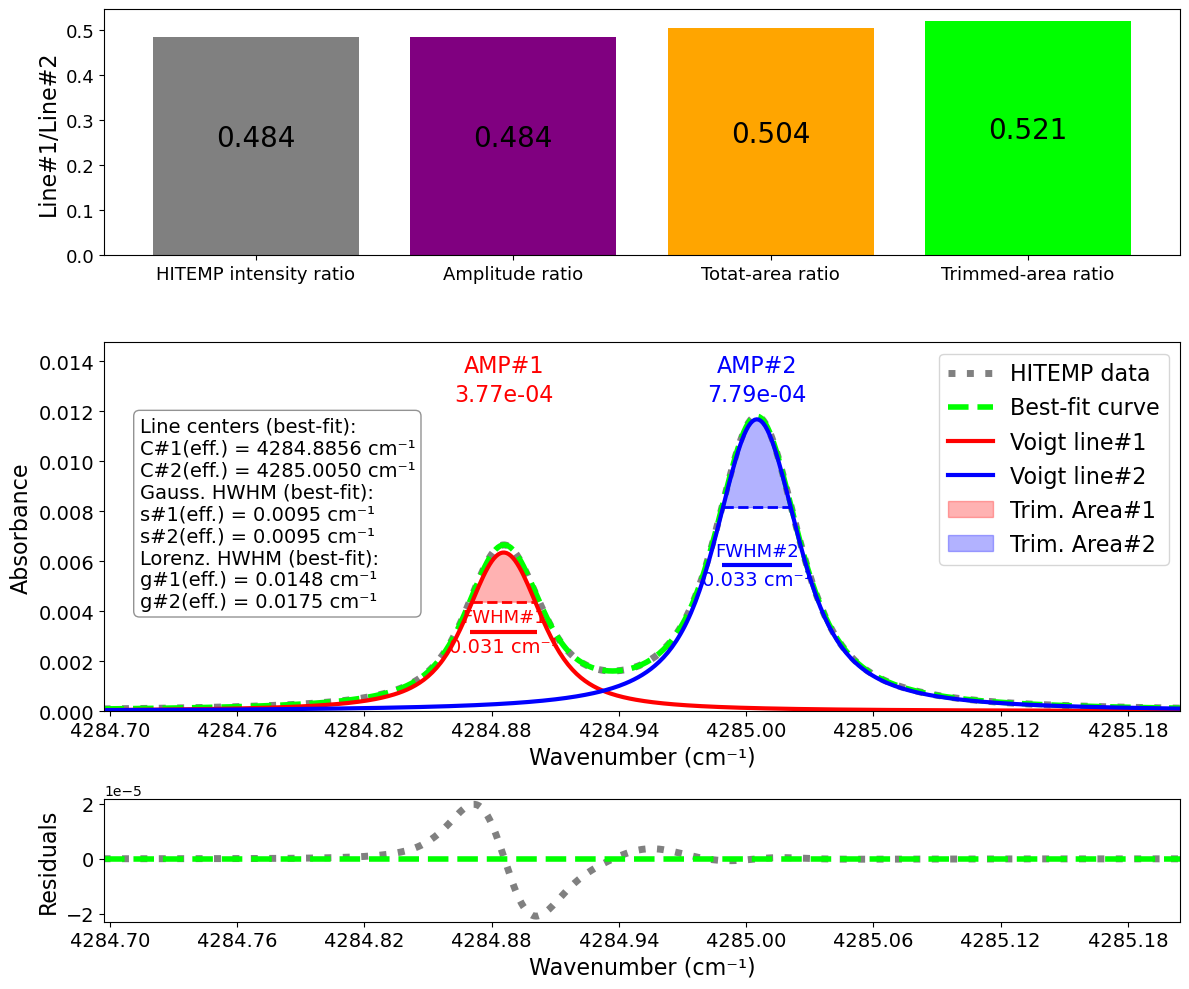

In [12]:
# ============================================
# Part 3b: Visualization of trimmed areas
# ============================================

import matplotlib.ticker as mticker
from math import floor, ceil

fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios':[2,3,1]})

# Ratio panel
cats = ['HITEMP intensity ratio', 'Amplitude ratio', 'Totat-area ratio', 'Trimmed-area ratio']
vals = [a1_guess/a2_guess, a1/a2, area1_total/area2_total, area1_trim/area2_trim]
ax3.bar(cats, vals, color=['gray', 'purple', 'orange', 'lime'])
ax3.set_ylabel("Line#1/Line#2", fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=13)

ax3.text(0, ratio_db/2, f"{ratio_db:.3f}", color='black', ha='center', fontsize=20)
ax3.text(1, ratio_amp/2, f"{ratio_amp:.3f}", color='black', ha='center', fontsize=20)
ax3.text(2, ratio_total/2, f"{ratio_total:.3f}", color='black', ha='center', fontsize=20)
ax3.text(3, ratio_trim/2, f"{ratio_trim:.3f}", color='black', ha='center', fontsize=20)

# Data + fit + components
ax1.plot(x_wn, y, color='grey', ls="dotted", lw=5, label='HITEMP data')
ax1.plot(x_wn, y_total, color='lime', label='Best-fit curve', linewidth=4, linestyle="dashed")
ax1.plot(x_wn, y1, color='red', lw=3, label='Voigt line#1')
ax1.plot(x_wn, y2, color='blue', lw=3, label='Voigt line#2')

# Fill trimmed areas
ax1.hlines(base1, xL1, xR1, colors='red', linestyles='--', linewidth=2)
ax1.fill_between(xi1, yi1, base1, where=(yi1 > base1), color='red', alpha=0.3, label='Trim. Area#1')
ax1.text(c1_fit, max(y)*1.15, f"AMP#1", color='red', ha='center', fontsize=16)
ax1.text(c1_fit, max(y)*1.05, f"{a1:.2e}", color='red', ha='center', fontsize=16)

ax1.hlines(base2, xL2, xR2, colors='blue', linestyles='--', linewidth=2)
ax1.fill_between(xi2, yi2, base2, where=(yi2 > base2), color='blue', alpha=0.3, label='Trim. Area#2')
ax1.text(c2_fit, max(y)*1.15, f"AMP#2", color='blue', ha='center', fontsize=16)
ax1.text(c2_fit, max(y)*1.05, f"{a2:.2e}", color='blue', ha='center', fontsize=16)

#ax1.set_title("Deconvoluted Voigt line fits with inflection-point based (trimmed) integrals", fontsize=20)
leg = ax1.legend(loc='best', fontsize=16)

# Axis labels (double-sized) and ticks
ax1.set_xlabel("Wavenumber (cm⁻¹)", fontsize=16)
#ax1.set_ylabel("Cross-section (cm$^2$/molecule)", fontsize=16)
ax1.set_ylabel("Absorbance", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Ensure plain integer x-axis ticks (remove scientific offset like +4.2848e3)
sf = mticker.ScalarFormatter(useMathText=False)
sf.set_useOffset(False)
ax1.xaxis.set_major_formatter(sf)

# Restrict to integer ticks within range
#xmin, xmax = x_wn.min(), x_wn.max()
xmin, xmax = c1_fit-6*fwhm1, c2_fit+6*fwhm2
ymin, ymax = 0 , max(y)*1.25
ax1.set_ylim(ymin, ymax)
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, prune='both'))

# Line 1 half-maximum baseline (FWHM line) and HWHM text at baseline level
y0_1 = voigt_wn(c1_fit, c1_fit, a1, sigma, g1)       # peak intensity
y_half_1 = y0_1 / 2.0
x1_fwhm_left = c1_fit - fwhm1/2
x1_fwhm_right = c1_fit + fwhm1/2
ax1.hlines(y_half_1, x1_fwhm_left, x1_fwhm_right, colors='red', linestyles='-', linewidth=3)
ax1.text(c1_fit, y_half_1 + 0.033*y.max(), f"FWHM#1", color='red', ha='center', fontsize=13)
ax1.text(c1_fit, y_half_1 - 0.067*y.max(), f"{fwhm1:.3f} cm⁻¹", color='red', ha='center', fontsize=14)

# Line 2 half-maximum baseline (FWHM line) and HWHM text
y0_2 = voigt_wn(c2_fit, c2_fit, a2, sigma, g2)
y_half_2 = y0_2 / 2.0
x2_fwhm_left = c2_fit - fwhm2/2
x2_fwhm_right = c2_fit + fwhm2/2
ax1.hlines(y_half_2, x2_fwhm_left, x2_fwhm_right, colors='blue', linestyles='-', linewidth=3)
ax1.text(c2_fit, y_half_2 + 0.033*y.max(), f"FWHM#2", color='blue', ha='center', fontsize=13)
ax1.text(c2_fit, y_half_2 - 0.067*y.max(), f"{fwhm2:.3f} cm⁻¹", color='blue', ha='center', fontsize=14)


# Panel with centers under legend, right side
centers_info = (
    f"Line centers (best-fit):\n"
    f"C#1(eff.) = {c1_fit:.4f} cm⁻¹\n"
    f"C#2(eff.) = {c2_fit:.4f} cm⁻¹\n"
    f"Gauss. HWHM (best-fit):\n"
    f"s#1(eff.) = {sigma:.4f} cm⁻¹\n"
    f"s#2(eff.) = {sigma:.4f} cm⁻¹\n"
    f"Lorenz. HWHM (best-fit):\n"
    f"g#1(eff.) = {g1:.4f} cm⁻¹\n"
    f"g#2(eff.) = {g2:.4f} cm⁻¹"
)
ax1.text(
    0.033,0.8, centers_info,
    transform=ax1.transAxes,
    fontsize=14,
    va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='gray')
)

# Residuals
res = y - y_total
ax2.plot(x_wn, res, color='gray',  ls='dotted', lw=5)
ax2.axhline(0, color='lime', ls='--', lw=4)
ax2.set_ylabel("Residuals", fontsize=16)
ax2.set_xlabel("Wavenumber (cm⁻¹)", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.set_major_formatter(sf)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, prune='both'))
ax2.set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()

# Nastav velikost figure na A4 (portrait)
#fig.set_size_inches(8.27, 11.69)

# Uložení do PDF
fig.savefig("fit2voigt.pdf", format="pdf", bbox_inches="tight")